# Sea Surface Temperature Processing for Frontend Visualization

This notebook processes MODIS SST4 (Sea Surface Temperature) data and exports it as JSON for the React frontend.

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import json
from datetime import datetime

# Get the dataset directory
dataset_dir = f"{os.path.dirname(os.getcwd())}/datasets"
temp_dir = f"{dataset_dir}/realtime_sea_surface_temperature_day_night"

print(f"Temperature data directory: {temp_dir}")

Temperature data directory: /home/luke/Code/wolfram-nasa-hackathon-2025/datasets/realtime_sea_surface_temperature_day_night


In [2]:
# List available temperature files
temp_files = sorted(glob.glob(f"{temp_dir}/AQUA_MODIS.*.L3m.*.SST4.sst4.*.nc"))
print(f"Found {len(temp_files)} temperature data files\n")

# Show the most recent files
print("Most recent files:")
for file in temp_files[-5:]:
    print(f"  {os.path.basename(file)}")

Found 26 temperature data files

Most recent files:
  AQUA_MODIS.20251001.L3m.DAY.SST4.sst4.9km.NRT.nc
  AQUA_MODIS.20251002.L3m.DAY.SST4.sst4.4km.NRT.nc
  AQUA_MODIS.20251002.L3m.DAY.SST4.sst4.9km.NRT.nc
  AQUA_MODIS.20251003.L3m.DAY.SST4.sst4.4km.NRT.nc
  AQUA_MODIS.20251003.L3m.DAY.SST4.sst4.9km.NRT.nc


In [3]:
# Load the most recent daily file (9km resolution for faster processing)
# We'll use 9km resolution files as they're smaller but still provide good coverage
daily_9km_files = [f for f in temp_files if '.L3m.DAY.' in f and '.9km.' in f]

if daily_9km_files:
    # Use the most recent daily file
    latest_file = daily_9km_files[-1]
else:
    # Fallback to any 9km file
    km9_files = [f for f in temp_files if '.9km.' in f]
    latest_file = km9_files[-1] if km9_files else temp_files[-1]

print(f"Loading: {os.path.basename(latest_file)}")

# Open the dataset
ds = xr.open_dataset(latest_file)
print(f"\nDataset info:")
print(f"  Variables: {list(ds.data_vars)}")
print(f"  Dimensions: {ds.dims}")
print(f"  Coordinates: {list(ds.coords)}")

Loading: AQUA_MODIS.20251003.L3m.DAY.SST4.sst4.9km.NRT.nc

Dataset info:
  Variables: ['sst4', 'qual_sst4', 'palette']
  Dimensions: FrozenMappingWarningOnValuesAccess({'lat': 2160, 'lon': 4320, 'rgb': 3, 'eightbitcolor': 256})
  Coordinates: ['lat', 'lon']


In [4]:
# Extract SST4 data
sst = ds['sst4']
lons = ds['lon'].values
lats = ds['lat'].values

print(f"SST4 shape: {sst.shape}")
print(f"Longitude range: [{lons.min():.2f}, {lons.max():.2f}]")
print(f"Latitude range: [{lats.min():.2f}, {lats.max():.2f}]")

# Get temperature statistics (excluding NaN values)
sst_values = sst.values
valid_temps = sst_values[~np.isnan(sst_values)]
if len(valid_temps) > 0:
    print(f"\nTemperature statistics (°C):")
    print(f"  Min: {valid_temps.min():.2f}")
    print(f"  Max: {valid_temps.max():.2f}")
    print(f"  Mean: {valid_temps.mean():.2f}")
    print(f"  Valid points: {len(valid_temps):,} / {sst_values.size:,}")

SST4 shape: (2160, 4320)
Longitude range: [-179.96, 179.96]
Latitude range: [-89.96, 89.96]

Temperature statistics (°C):
  Min: -1.58
  Max: 33.41
  Mean: 21.33
  Valid points: 1,801,988 / 9,331,200


In [5]:
# Process temperature data for heatmap visualization
# Export ACTUAL temperature values in Celsius - NO normalization

# Prepare heatmap data in [lat, lng, temperature_celsius] format
heat_data = []

# Sample the data to balance resolution and performance
# Moderate sampling for good visual quality without overwhelming the browser
sample_factor = 10 if '.9km.' in latest_file else 20

print(f"Processing temperature data with sampling factor: {sample_factor}")
print(f"This will create a grid with approximately {len(lons)//sample_factor} x {len(lats)//sample_factor} points")

for i in range(0, len(lons), sample_factor):
    for j in range(0, len(lats), sample_factor):
        temp_celsius = sst_values[j, i]  # Note: NetCDF typically stores as (lat, lon)
        
        if not np.isnan(temp_celsius):
            # Convert lon from 0-360 to -180-180 if needed
            lon = float(lons[i])
            if lon > 180:
                lon = lon - 360
            
            # Store ACTUAL temperature value in Celsius - NO NORMALIZATION
            heat_data.append([float(lats[j]), lon, float(temp_celsius)])

print(f"\nGenerated {len(heat_data):,} temperature points (sampled every {sample_factor} points)")

# Calculate actual resolution in degrees
if '.9km.' in latest_file:
    # 9km files are typically 0.09 degree resolution
    grid_resolution = sample_factor * 0.09
else:
    # 4km files are typically 0.04 degree resolution  
    grid_resolution = sample_factor * 0.04
    
print(f"Grid resolution: approximately {grid_resolution:.2f} degrees (~{grid_resolution * 111:.0f} km at equator)")

# Show actual temperature range in the exported data
temps_in_data = [point[2] for point in heat_data]
print(f"\nActual temperature range in exported data: {min(temps_in_data):.1f}°C to {max(temps_in_data):.1f}°C")
print(f"Mean temperature: {np.mean(temps_in_data):.1f}°C")

# Verify we have variation by checking some specific regions
equator_temps = [p[2] for p in heat_data if -10 < p[0] < 10]
arctic_temps = [p[2] for p in heat_data if p[0] > 60]
antarctic_temps = [p[2] for p in heat_data if p[0] < -60]

if equator_temps:
    print(f"\nEquatorial region temps: {min(equator_temps):.1f}°C to {max(equator_temps):.1f}°C")
if arctic_temps:
    print(f"Arctic region temps: {min(arctic_temps):.1f}°C to {max(arctic_temps):.1f}°C")
if antarctic_temps:
    print(f"Antarctic region temps: {min(antarctic_temps):.1f}°C to {max(antarctic_temps):.1f}°C")

Processing temperature data with sampling factor: 10
This will create a grid with approximately 432 x 216 points

Generated 18,079 temperature points (sampled every 10 points)
Grid resolution: approximately 0.90 degrees (~100 km at equator)

Actual temperature range in exported data: -1.0°C to 32.8°C
Mean temperature: 21.3°C

Equatorial region temps: 16.1°C to 30.8°C
Arctic region temps: -0.6°C to 13.2°C
Antarctic region temps: 0.5°C to 4.0°C


In [6]:
# Save temperature data to JSON for frontend
output_path = '../frontend/src/pages/landing/temperature_data.json'

with open(output_path, 'w') as f:
    json.dump(heat_data, f)

print(f"Saved temperature data to {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")

Saved temperature data to ../frontend/src/pages/landing/temperature_data.json
File size: 1.02 MB


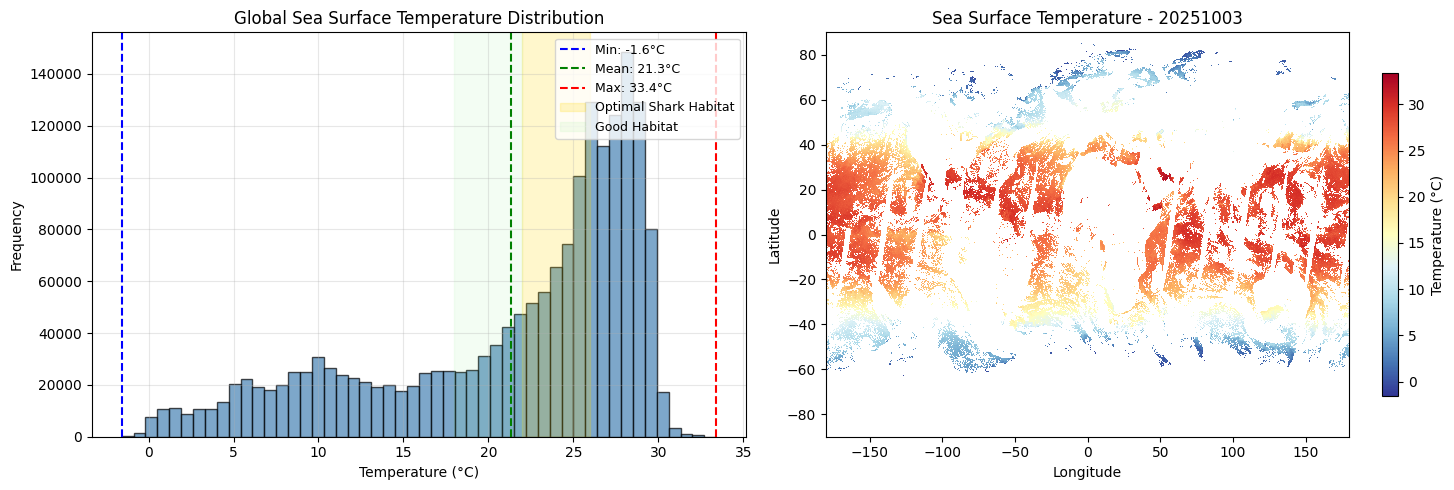


Visualization complete.


In [7]:
# Optional: Create a sample visualization to verify the data
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a simple plot to verify the temperature distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Temperature distribution histogram
ax1.hist(valid_temps, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(valid_temps.min(), color='blue', linestyle='--', label=f'Min: {valid_temps.min():.1f}°C')
ax1.axvline(valid_temps.mean(), color='green', linestyle='--', label=f'Mean: {valid_temps.mean():.1f}°C')
ax1.axvline(valid_temps.max(), color='red', linestyle='--', label=f'Max: {valid_temps.max():.1f}°C')

# Add shark habitat zones
ax1.axvspan(22, 26, alpha=0.2, color='gold', label='Optimal Shark Habitat')
ax1.axvspan(18, 22, alpha=0.1, color='lightgreen', label='Good Habitat')

ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Frequency')
ax1.set_title('Global Sea Surface Temperature Distribution')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Global temperature map
# Use a warm colormap for temperature
cmap = plt.cm.RdYlBu_r  # Red-Yellow-Blue reversed (warm colors for high temps)
norm = mcolors.Normalize(vmin=valid_temps.min(), vmax=valid_temps.max())

# Create meshgrid for plotting
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Plot the temperature data
im = ax2.pcolormesh(lon_grid, lat_grid, sst_values, cmap=cmap, norm=norm, shading='auto')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title(f'Sea Surface Temperature - {os.path.basename(latest_file).split(".")[1]}')
ax2.set_xlim(-180, 180)
ax2.set_ylim(-90, 90)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, label='Temperature (°C)', shrink=0.8)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete.")